In [1]:
import sympy
sympy.init_printing()

In [2]:
def si_drived_unit_equivalent(unit_string:str) -> str:
    assert ' ' not in unit_string, 'Invalid space character'
    
    si_drived_units = {'N': 'kg m s^-2', 'J': 'kg m^2 s^-2', 'C':'A s',
                       'T': 'kg s^-2 A^-1', 'Pa':'kg m^-1 s^-2',
                       'W':'kg m^2 s^-3', 'Hz':'s^-1', 'V':'kg m^2 s^-3 A^-1',
                       'F':'kg^-1 m^-2 s^4 A^2', 'Wb':'kg m^2 s^-2 A^-1',
                       'H':'kg m^2 s^-2 A^-2', 'ohm':'kg m^2 s^-3 A^-2',
                       'rad':'', 'sr':''}
    
    if '^' in unit_string:
        unit_part = unit_string.split('^')[0]
        power_part = int(unit_string.split('^')[1])
    else:
        unit_part = unit_string
        power_part = 1
    
    if unit_part in si_drived_units:
        unit_part = si_drived_units[unit_part]            
        unit_list = [unit_part for instance in range(power_part)]
        return ' '.join(unit_list)
    else:    
        return unit_string

def symplify_drived_units(unit_string:str) -> str:
    unit_list = []
    for unit in unit_string.split(' '):
        unit_list.append(si_drived_unit_equivalent(unit))
    return ' '.join(unit_list)

In [3]:
def si_parser(unit_string:str) -> dict:
    from sympy.physics import units
    
    si_system = {'m': units.length, 's': units.time,
                 'k': units.temperature, 'kg': units.mass,
                 'mol': units.amount_of_substance, 'A': units.current,
                 'cd': units.luminous_intensity}
    unit_string = symplify_drived_units(unit_string)
    
    result_unit = 1
    for unit in unit_string.split(' '):
        
        if '^' in unit:
            unit_part = unit.split('^')[0]
            power_part = int(unit.split('^')[1])
        else:
            unit_part = unit
            power_part = 1            
        
        result_unit *= (si_system[unit_part]**power_part)

    return result_unit

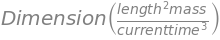

In [4]:
f = si_parser('V')
f

# Dimensional Analysis

In [5]:
def parameter(name:str, unit:str, latex_repr:str):
    from sympy.physics.units import Quantity
    from sympy.physics.units.systems import SI
    
    parameter = Quantity(name, latex_repr=latex_repr)
    SI.set_quantity_dimension(parameter, si_parser(unit))
    return parameter

In [6]:
class DimensionalAnalysis:
    def __init__(self, paramters:list):
        self.parameters = paramters
        
    @property
    def fundamental_dimensions(self):
        from sympy.physics.units.systems.si import dimsys_SI
        dimensions = set()
        for parameter in self.parameters:
            dimension_dict = dimsys_SI.get_dimensional_dependencies(parameter.dimension)
            for dimension in dimension_dict:
                dimensions.add(dimension)
        return dimensions
    
    @property
    def dimension_matrix(self):
        from sympy.physics.units.systems.si import dimsys_SI
        matrix = sympy.zeros(len(self.fundamental_dimensions),
                             len(self.parameters))
        for i, dimension in enumerate(self.fundamental_dimensions):
            for j, parameter in enumerate(self.parameters):
                dimension_dict = dimsys_SI.get_dimensional_dependencies(parameter.dimension)
                if dimension in dimension_dict:
                    matrix[i,j] = dimension_dict[dimension]
                else:
                    matrix[i,j] = 0

        return matrix
    
    @property
    def dimensionless_parameters(self):
        dimesionless_dict = dict()
        nullspace = self.dimension_matrix.nullspace()
        for i, vector in enumerate(nullspace):
            d = 1
            for j, power in enumerate(vector):
                if power - int(power) == 0:
                    power = int(power) # Prefer using integer powers if possible
                d *= (self.parameters[j]**power)
                dimesionless_dict[sympy.symbols(f'Pi_{i}')] = d

        return dimesionless_dict
    
    def solve_for(self, parameter):
        solution_dict = dict()
        dimensionless_dict = self.dimensionless_parameters
        for d in dimensionless_dict:
            solution = sympy.solve(sympy.Eq(dimensionless_dict[d], d),
                                   parameter)
            solution_dict[d] = solution
        return solution_dict

In [7]:
def dimensional_analysis(*args):
    analyze = DimensionalAnalysis([*args])
    return analyze.dimensionless_parameters

def solve_from_dimensional_analysis(*args, target_parameter):
    analyze = DimensionalAnalysis([*args])
    return analyze.solve_for(target_parameter)

In [8]:
def standard_parameters(parameters_string:str) -> list:
    parameter_list = parameters_string.split(' ')
    # 1D Length related parameters
    length = parameter('Length', 'm', 'L')
    width = parameter('Width', 'm', 'L')
    height = parameter('Height', 'm', 'h')
    diameter = parameter('Diameter', 'm', 'D')
    radius = parameter('Radius', 'm', 'r')
    
    # 2D Length related parameters
    area = parameter('Area', 'm^2', 'A')
    
    # 3D Length related parameters
    volume = parameter('Volume', 'm^2', 'V')
    
    # Mechanic related parameters
    mass = parameter('Mass', 'kg', 'm')
    velocity = parameter('Velocity', 'm s^-1', 'v')
    acceleration = parameter('Acceleration', 'm s^-2', 'a')
    g = parameter('g', 'm s^-2', 'g')
    force = parameter('Force', 'N', 'F')
    momentum = parameter('Momentum', 'kg m s^-1', 'p')
    period = parameter('Period', 's', 'T')
    frequency = parameter('Frequency', 's^-1', 'f')
    energy = parameter('Energy', 'J', 'E')
    work = parameter('Work', 'J', 'W')
    potential_energy = parameter('Potential Energy', 'J', 'PE')
    kinetic_energy = parameter('Kinetic Energy', 'J', 'KE')
    
    
    # Fluid mechanic parameters
    density = parameter('Density', 'kg m^-3', '\\rho')
    viscosity = parameter('Viscosity', 'kg m^-1 s^-1', '\mu')
    pressure = parameter('Pressure', 'Pa', 'P')
    temperature = parameter('Temperature', 'k', 'T')
    heat = parameter('Heat', 'J', 'Q')
    
    # Wave related parameters   
    wave_length = parameter('Wave Length', 'm', '\lambda')
    
    # Electric related parameters
    electric_current = parameter('Electric Current', 'A', 'I')
    electric_voltage = parameter('Electric Voltage', 'V', 'V')
    electric_resistance = parameter('Electric Resistance', 'ohm', 'R')
    electric_charge = parameter('Electric Charge', 'A s', 'q')
    
    # Magnetic related parameters
    magnetic_field = parameter('Magnetic Field', 'T', 'B')
    
    
    
    standard_quantities = {
        'length': length,
        'width': width,
        'height': height,
        'diameter': diameter,
        'radius': radius,
        'area': area,
        'volume': volume,
        'mass': mass,
        'velocity': parameter('Velocity', 'm s^-1', 'v'),
        'acceleration': velocity,
        'g': g,
        'force': force,
        'momentum': momentum,
        'period': period,
        'frequency': frequency,
        'energy': energy,
        'work': work,
        'potential_energy': potential_energy,
        'kinetic_energy': kinetic_energy,
        'density': density,
        'viscosity': viscosity,
        'pressure': pressure,
        'temperature':temperature,
        'heat': heat,
        'wave_length': wave_length,
        'electric_current': electric_current,
        'electric_voltage': electric_voltage,
        'electric_resistance': electric_resistance,
        'electric_charge': electric_charge,
        'magnetic_field': magnetic_field
    }
    
    parameters = [standard_quantities[p] for p in parameter_list]
    return parameters
    

In [9]:
standard_parameters('heat temperature density')

In [43]:
def standard_dimensional_analysis(parameters_string:str):
    parameters = standard_parameters(parameters_string)
    return dimensional_analysis(*parameters)

def solve_from_standard_dimensional_analysis(parameters_string:str, target_parameter_string:str):
    parameters = standard_parameters(parameters_string)
    target_parameter = standard_parameters(target_parameter_string)[0]
    return solve_from_dimensional_analysis(*parameters, target_parameter=target_parameter)

# Manual Dimensional Analysis

In [44]:
density = parameter('density', 'kg m^-3', '\\rho')
viscosity = parameter('viscosity', 'kg m^-1 s^-1', '\mu')
velocity = parameter('velocity', 'm s^-1', 'u')
diameter = parameter('diameter', 'm', 'D')

In [45]:
dimensional_analysis(density, viscosity, velocity, diameter)

In [46]:
solve_from_dimensional_analysis(density, viscosity, velocity, diameter, target_parameter=velocity)

# Automated Standard Dimensional Analysis

## Kinetic Energy

In [47]:
standard_dimensional_analysis('kinetic_energy mass velocity')

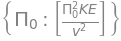

In [51]:
solve_from_standard_dimensional_analysis('kinetic_energy mass velocity', 'mass')

## Fluid Flow

In [15]:
standard_dimensional_analysis('density viscosity velocity diameter')

## Pendulum

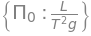

In [16]:
standard_dimensional_analysis('period g length')

## Fluid Static

In [17]:
standard_dimensional_analysis('pressure density g height')

## Wave Equation

In [18]:
standard_dimensional_analysis('wave_length velocity period')

## Magnetic Force

In [19]:
standard_dimensional_analysis('magnetic_field force electric_current length')

In [52]:
solve_from_standard_dimensional_analysis('magnetic_field force electric_current length', 'force')